Fault Analysis Pipeline for Industrial Alarm Logs
This notebook demonstrates how to:
 - Load processed alarm sequences
 - Simulate live data (by splitting past and future data)
 - Train an autoencoder for anomaly detection and latent feature extraction
 - Cluster latent representations with KMeans for fault detection
 - Visualize results using t-SNE and compute cluster compactness metrics
 - Display sample sequences with predicted fault clusters and distances to centroids

# 1. Setup and Data Loading

In [1]:
# ------------------------------
# 1. Setup and Data Loading
# ------------------------------
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import layers, models, callbacks
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

# Download the preprocessed data (if not already present)
data_url = "https://github.com/Nurath/Capstone/raw/refs/heads/main/EDA%20And%20Preprocessing/alarm_sequences_for_models.pkl"
if not os.path.exists("alarm_sequences_for_models.pkl"):
    !wget -q {data_url}

# Load the preprocessed data structure
with open("alarm_sequences_for_models.pkl", "rb") as f:
    results = pickle.load(f)

# Choose one machine for demonstration (e.g., machine with serial 3)
machine_serial = 3
forecasting_data = results['forecasting'][machine_serial]
anomaly_data = results['anomaly_detection'][machine_serial]

# Convert anomaly detection sequences to numpy array (assumes sequences are padded)
data_array = np.array(anomaly_data)
print(f"Total sequences for machine {machine_serial}: {data_array.shape[0]}")

Total sequences for machine 3: 8693


# 2. Data Splitting: Past vs Future

In [2]:
# ------------------------------
# 2. Data Splitting: Past vs Future
# ------------------------------
# Use 70% of sequences as "past" (training) data and the remaining 30% as "future" (live simulation)
split_index = int(0.7 * len(data_array))
train_data = data_array[:split_index]
future_data = data_array[split_index:]
print(f"Training sequences shape: {train_data.shape}")
print(f"Simulated future sequences shape: {future_data.shape}")

Training sequences shape: (6085, 10)
Simulated future sequences shape: (2608, 10)


# 3. Build and Train the Autoencoder

In [3]:
# ------------------------------
# 3. Build and Train the Autoencoder
# ------------------------------
input_dim = train_data.shape[1]  # Sequence length
encoding_dim = 32  # Dimension of latent space

# Define the autoencoder model
input_seq = layers.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation='relu', name='encoder_layer')(input_seq)
decoded = layers.Dense(input_dim, activation='linear', name='decoder_layer')(encoded)
autoencoder = models.Model(input_seq, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

# Create a separate encoder model for latent extraction
encoder = models.Model(input_seq, encoded)

# Train the autoencoder
early_stop = callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
history = autoencoder.fit(train_data, train_data,
                          epochs=50,
                          batch_size=32,
                          shuffle=True,
                          validation_split=0.2,
                          callbacks=[early_stop])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_layer (Dense)                │ (None, 32)                  │             352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_layer (Dense)                │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 682 (2.66 KB)

 Trainable params: 682 (2.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 4491.7119 - val_loss: 1045.9170
Epoch 2/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 755.9499 - val_loss: 283.7357
Epoch 3/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 193.3222 - val_loss: 72.8239
Epoch 4/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 45.1731 - val_loss: 28.8245
Epoch 5/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.5036 - val_loss: 17.7144
Epoch 6/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 11.7544 - val_loss: 12.3418
Epoch 7/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.1464 - val_loss: 8.9660
Epoch 8/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.6743 - val_loss: 6.5203
Epoch 9/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8098 - val_loss: 4.8697
Epoch 10/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6977 - val_loss: 3.5602
Epoch 11/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.8927 - val_loss: 2.6669
Epoch 12/50
153/153 ━━━━━━━━━━━━━

# 4. Evaluate on Future Data & Anomaly Detection

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


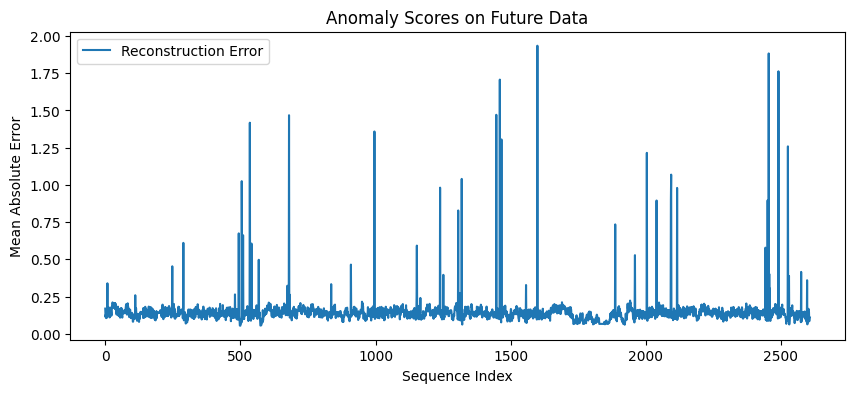

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Anomaly detection threshold set at: 0.1807
Detected 201 anomalous sequences out of 2608


In [4]:
# ------------------------------
# 4. Evaluate on Future Data & Anomaly Detection
# ------------------------------
reconstructions = autoencoder.predict(future_data)
reconstruction_errors = np.mean(np.abs(future_data - reconstructions), axis=1)

plt.figure(figsize=(10, 4))
plt.plot(reconstruction_errors, label="Reconstruction Error")
plt.title("Anomaly Scores on Future Data")
plt.xlabel("Sequence Index")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.show()

# Set anomaly threshold using the 95th percentile from training errors
train_reconstructions = autoencoder.predict(train_data)
train_errors = np.mean(np.abs(train_data - train_reconstructions), axis=1)
threshold = np.quantile(train_errors, 0.95)
print(f"Anomaly detection threshold set at: {threshold:.4f}")

anomalies = future_data[reconstruction_errors > threshold]
print(f"Detected {len(anomalies)} anomalous sequences out of {len(future_data)}")

# 5. Clustering in Latent Space

In [5]:
# ------------------------------
# 5. Clustering in Latent Space
# ------------------------------
# Extract latent representations for training and future data
train_latent = encoder.predict(train_data)
future_latent = encoder.predict(future_data)

# Perform KMeans clustering on training latent features
num_clusters = 4  # Adjust as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
train_clusters = kmeans.fit_predict(train_latent)
future_clusters = kmeans.predict(future_latent)

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


# 6. Visualization & Metrics

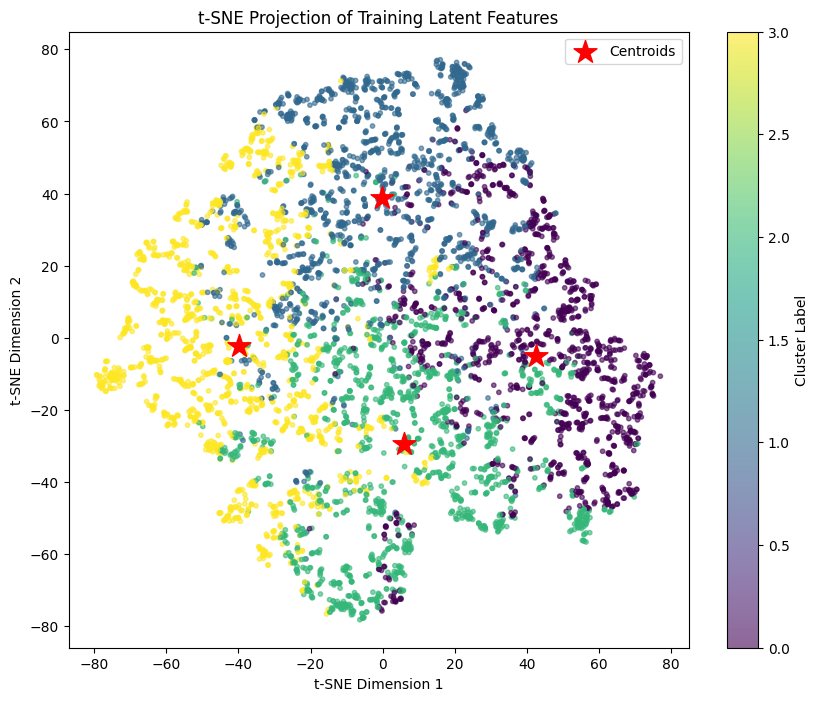

Overall Silhouette Score (Training): 0.13779491


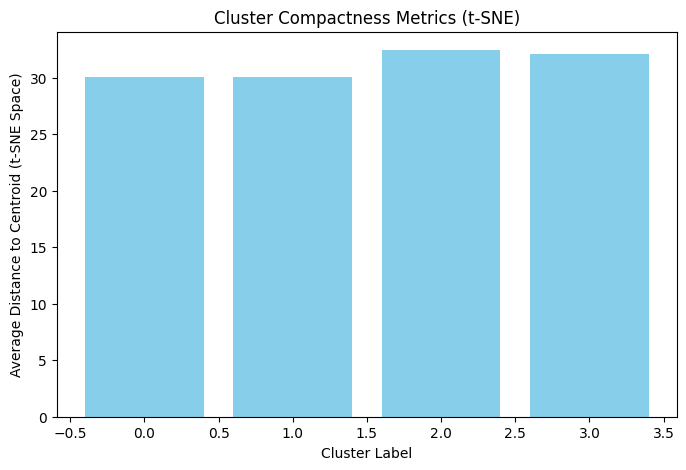

In [6]:
# ------------------------------
# 6. Visualization & Metrics
# ------------------------------
# Helper Function: Euclidean distance
def compute_distance(vector, centroid):
    return np.linalg.norm(vector - centroid)

# --- t-SNE Visualization ---
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(train_latent)
unique_clusters = np.unique(train_clusters)

# Compute centroids in t-SNE space (by averaging points per cluster)
centroids_tsne = np.array([tsne_results[train_clusters == cluster].mean(axis=0)
                           for cluster in unique_clusters])

plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1],
                      c=train_clusters, cmap='viridis', alpha=0.6, s=10)
plt.scatter(centroids_tsne[:, 0], centroids_tsne[:, 1],
            marker='*', s=300, c='red', label='Centroids')
plt.colorbar(scatter, label='Cluster Label')
plt.title('t-SNE Projection of Training Latent Features')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()

# Compute overall silhouette score
sil_score = silhouette_score(train_latent, train_clusters)
print("Overall Silhouette Score (Training):", sil_score)

# --- Distance Metrics in t-SNE Space ---
tsne_future = tsne.fit_transform(future_latent)  # Project future data for visualization

# Compute distances to centroids in t-SNE space for training samples
distances_tsne = np.array([compute_distance(tsne_results[i], centroids_tsne[train_clusters[i]])
                           for i in range(len(tsne_results))])
avg_distances_tsne = [np.mean([compute_distance(tsne_results[i], centroids_tsne[cluster])
                               for i in np.where(train_clusters == cluster)[0]])
                      for cluster in unique_clusters]

plt.figure(figsize=(8, 5))
plt.bar(unique_clusters, avg_distances_tsne, color='skyblue')
plt.xlabel('Cluster Label')
plt.ylabel('Average Distance to Centroid (t-SNE Space)')
plt.title('Cluster Compactness Metrics (t-SNE)')
plt.show()

# 7. Display Sample Results with Metrics


Sample Future Sequences with Predicted Cluster Labels and Distance to Centroid:

Sequence 1186:
Alarms: [ 97  11 139  79  11 139  97 127 139  11]
Predicted Cluster (Fault Type): 0
Distance to Centroid: 198.8793
--------------------------------------------------
Sequence 928:
Alarms: [ 28 139 138  97  11 139  27  73  11 139]
Predicted Cluster (Fault Type): 1
Distance to Centroid: 140.0824
--------------------------------------------------
Sequence 1943:
Alarms: [119 139 119 139 127  11 127 139 138 139]
Predicted Cluster (Fault Type): 0
Distance to Centroid: 214.8002
--------------------------------------------------
Sequence 2150:
Alarms: [115  11 111 139  11 139  29  97 139  11]
Predicted Cluster (Fault Type): 1
Distance to Centroid: 189.3003
--------------------------------------------------
Sequence 1394:
Alarms: [139  51   9 139  27 139   9 139   9 139]
Predicted Cluster (Fault Type): 1
Distance to Centroid: 174.1276
--------------------------------------------------


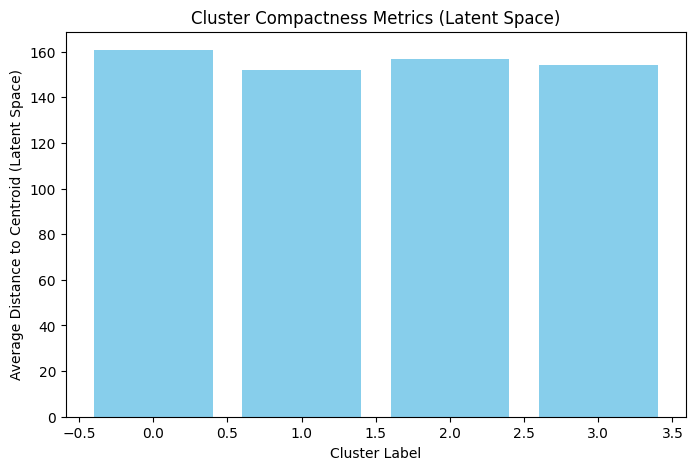

In [7]:
# ------------------------------
# 7. Display Sample Results with Metrics
# ------------------------------
# Use the simulated "future" data as the source for sample sequences
alarms_sequences = future_data       # Padded alarm sequences from future simulation
latent_features = future_latent      # Latent representations for future data
predicted_clusters = future_clusters # Predicted cluster labels for future sequences
centroids = kmeans.cluster_centers_  # Cluster centroids in latent space

# Build sample results (choose 5 random samples)
num_samples_to_show = 5
n_samples = len(alarms_sequences)
sample_indices = np.random.choice(n_samples, num_samples_to_show, replace=False)
sample_results = []
for idx in sample_indices:
    sample_results.append({
        'id': idx,
        'alarms': alarms_sequences[idx],
        'predicted_cluster': int(predicted_clusters[idx]),
        'latent': latent_features[idx]
    })

print("\nSample Future Sequences with Predicted Cluster Labels and Distance to Centroid:\n")
for sample in sample_results:
    seq_id = sample['id']
    alarms = sample['alarms']
    predicted_cluster = sample['predicted_cluster']
    latent_vector = sample['latent']
    distance = compute_distance(latent_vector, centroids[predicted_cluster])
    print(f"Sequence {seq_id}:")
    print("Alarms:", alarms)
    print("Predicted Cluster (Fault Type):", predicted_cluster)
    print("Distance to Centroid: {:.4f}".format(distance))
    print("-" * 50)

# Optionally, visualize overall distances in latent space
all_distances = np.array([compute_distance(latent_features[i], centroids[predicted_clusters[i]])
                          for i in range(n_samples)])
avg_distances = [np.mean([compute_distance(latent_features[i], centroids[cluster])
                          for i in np.where(predicted_clusters == cluster)[0]])
                 for cluster in np.unique(predicted_clusters)]

plt.figure(figsize=(8, 5))
plt.bar(np.unique(predicted_clusters), avg_distances, color='skyblue')
plt.xlabel('Cluster Label')
plt.ylabel('Average Distance to Centroid (Latent Space)')
plt.title('Cluster Compactness Metrics (Latent Space)')
plt.show()
